In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental import preprocessing

from risk_model import Model
from datetime import datetime

import plotly.graph_objects as go
from pandas_datareader import data as pdr
%matplotlib inline

from absl import logging
tf.get_logger().setLevel('ERROR')

float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
tf.random.set_seed(123)

np.random.seed(123)


very_small_float = 1.0 #0.000000001

In [2]:
from bt_testcode import backtest, DynRebalance, get_name, plotAllocation, getStatistic, calc_portfolio_values
from bt_testcode import plotPortfolioReturns, get_portfolio_values

# Test Model

In [3]:
ticker = ['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY']
history_range = {'start': datetime(2008, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

In [4]:
stock_close = stock.iloc[:125]['Close'].reset_index(drop=True).fillna(very_small_float)
stock_close.head()

Symbols,MSFT,AMD,C,BA,AMZN,AAPL,MO,AEE,AIG,WY
0,35.220001,7.14,289.200012,86.620003,96.250000,6.958571,74.930000,53.349998,1126.0,71.519997
1,35.369999,6.77,289.299988,86.980003,95.209999,6.961786,75.389999,53.310001,1129.0,72.199997
2,34.380001,6.25,282.399994,85.820000,88.790001,6.430357,74.900002,52.919998,1106.0,68.620003
3,34.610001,6.08,282.600006,82.870003,88.820000,6.344286,77.230003,53.610001,1126.0,68.129997
4,33.450001,6.00,271.399994,79.910004,87.879997,6.116071,78.320000,53.310001,1111.0,66.699997


In [5]:
rnd = 8
tf.random.set_seed(rnd)
np.random.seed(rnd)

param={}
param ={'model_params':
    {'model_n':'LSTM',
    'epochs':1000}}

m = Model()
alloc = m.get_allocations(stock_close.values, **param['model_params'])
alloc

array([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       0.0000, 0.0000], dtype=float32)

In [6]:
calc_portfolio_values(alloc, stock_close)

portfolio_returns: -0.1107
std: 0.0386
sharpe: -0.0231


In [7]:

n = [0, 200, 250, 300, 350, 400, 500, 700, 1000, 1300]
def getReturnFromAlloc(n):
    r_list = []
    param={}
    param ={'model_params':
        {'model_n':'LSTM',
        'epochs':1000}}
    print('ret, std, sharp')
    for i in n:
        stock_close = stock.iloc[i:i+125]['Close'].reset_index(drop=True).fillna(very_small_float)
        m = Model()
        alloc = m.get_allocations(stock_close.values, **param['model_params'])
        r_list.append((get_portfolio_values(alloc, stock_close)))
        #print(r_list[-1])
    return r_list

rl = getReturnFromAlloc(n)
sharp = []
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))
    sharp.append(sp)

pd.DataFrame({'LSTM':sharp}).to_csv('lstm_alloc_result.csv')

ret, std, sharp
-0.1107  0.0386  -0.0231
0.5594  0.0461  0.0979
0.5396  0.0258  0.1684
0.6085  0.0190  0.2582
0.5422  0.0163  0.2675
0.4586  0.0203  0.1826
0.2759  0.0195  0.1142
0.4196  0.0179  0.1890
0.1469  0.0079  0.1504
0.2743  0.0116  0.1900


In [45]:
ticker = ['SPY', 'TLT', 'GLD', 'RWO']
history_range = {'start': datetime(2010, 1, 1), 
                 'end': datetime(2020, 10, 1)}

stock = pdr.DataReader(ticker, 
                start=history_range['start'],
                end=history_range['end'],
                data_source='yahoo')

rl = getReturnFromAlloc(n)
sharp = []
for r, s, sp in rl:
    print("{:.4f}  {:.4f}  {:.4f}".format(r,s,sp))
    sharp.append(sp)

pd.DataFrame({'LSTM':sharp}).to_csv('lstm_alloc_result_2.csv')

ret, std, sharp
0.1284  0.0090  0.1150
0.1267  0.0074  0.1373
0.0697  0.0086  0.0653
0.2791  0.0122  0.1840
0.2317  0.0156  0.1196
0.1384  0.0156  0.0715
0.0738  0.0044  0.1343
0.1153  0.0068  0.1373
0.1239  0.0059  0.1705
-0.0326  0.0104  -0.0253


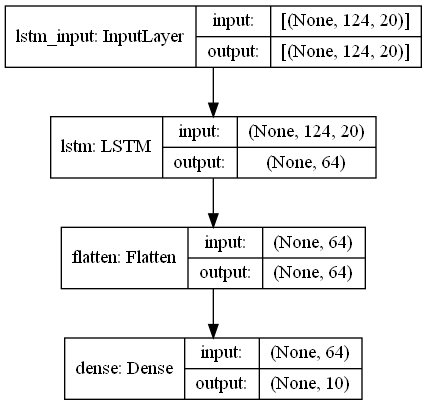

In [11]:
tf.keras.utils.plot_model(m.getModel(), show_shapes=True)

## Back test
Strategy:
We calculate the best assets allocations based on our model and we assue that this allocation will be the same for the next m days. We don't do any prediction of future returns.

# Back test 2008-2010

In [10]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    #'assets':['SPY', 'TLT', 'GLD', 'BA', 'SLV', 'WYNN','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2008, 1, 1),
    'endd'  : datetime(2010, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

Starting Portfolio Value: 11000.00
Final Portfolio Value: 15027.76


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM,10.944947,59.740399,0.132285,15027.760334


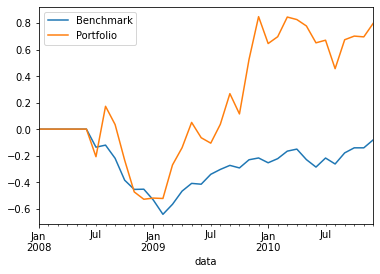

In [11]:
params['model'] = Model()
params['resetModel'] = False

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [13]:
plotAllocation(ah.dropna())

In [16]:
d_res = {}
d_stat = {}

Starting Portfolio Value: 11000.00
Final Portfolio Value: 3662.77


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,-30.654903,76.623344,-0.204514,3662.765179


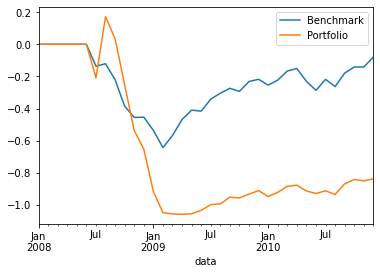

In [17]:
params['model'] = Model()
params['resetModel'] = True


d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [18]:
plotAllocation(ah.dropna())

In [19]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,-30.654903,76.623344,-0.204514,3662.765179


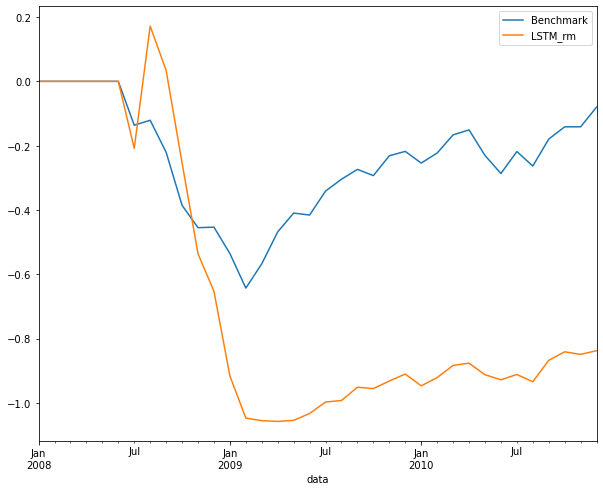

In [20]:
df = plotPortfolioReturns(d_res)

In [21]:
getStatistic(d_stat).to_csv('Lstm_stat_2008_2010.csv')
df.to_csv('Lstm_drawdown_2008_2010.csv')

# TEST 2011-2017

In [22]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2011, 1, 1),
    'endd'  : datetime(2017, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

Starting Portfolio Value: 11000.00
Final Portfolio Value: 64152.23


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,28.703126,30.059797,0.353001,64152.22577


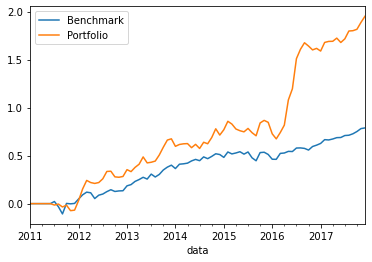

In [23]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [24]:
plotAllocation(ah.dropna())

In [25]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,28.703126,30.059797,0.353001,64152.22577


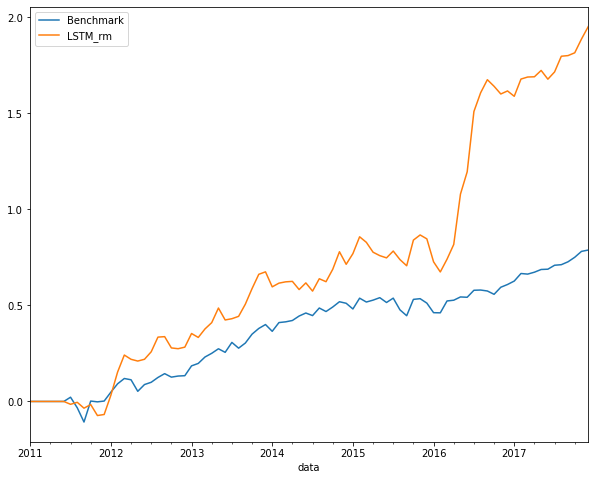

In [26]:
df = plotPortfolioReturns(d_res)

In [27]:
getStatistic(d_stat).to_csv('Lstm_stat_2011_2017.csv')
df.to_csv('Lstm_drawdown_2011_2017.csv')

# Test 2018-2021

In [28]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2018, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

Starting Portfolio Value: 11000.00
Final Portfolio Value: 15959.92


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,12.009199,28.594999,0.171562,15959.923067


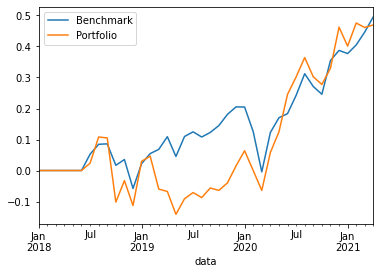

In [29]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [30]:
plotAllocation(ah.dropna())

In [31]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,12.009199,28.594999,0.171562,15959.923067


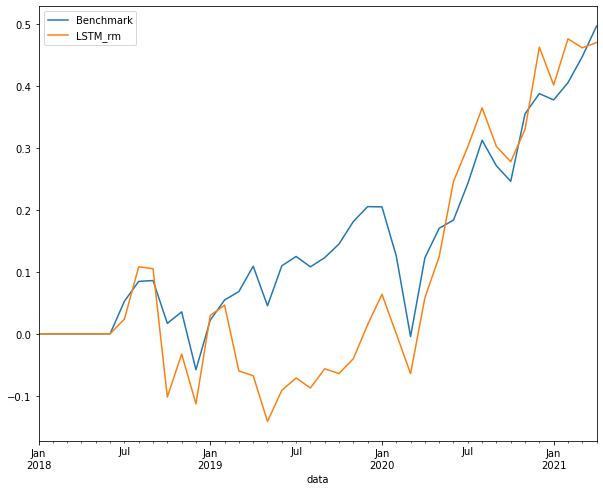

In [32]:
df = plotPortfolioReturns(d_res)

In [33]:
getStatistic(d_stat).to_csv('Lstm_stat_2018_2021.csv')
df.to_csv('Lstm_drawdown_2018_2021.csv')

# TEST 2012-2016

In [34]:
config_cerebro = {
    'assets':['MSFT', 'AMD', 'C', 'BA', 'AMZN', 'AAPL','MO', 'AEE', 'AIG', 'WY'],
    'benchmark':'SPY',
    'startd': datetime(2012, 1, 1),
    'endd'  : datetime(2016, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':100}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

Starting Portfolio Value: 11000.00
Final Portfolio Value: 20957.28


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,13.78302,21.611383,0.260804,20957.279299


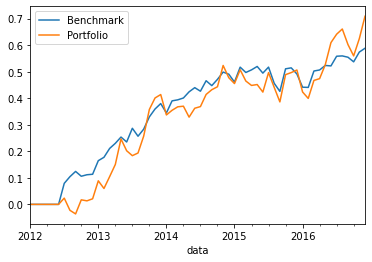

In [35]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [36]:
plotAllocation(ah.dropna())

In [37]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,13.78302,21.611383,0.260804,20957.279299


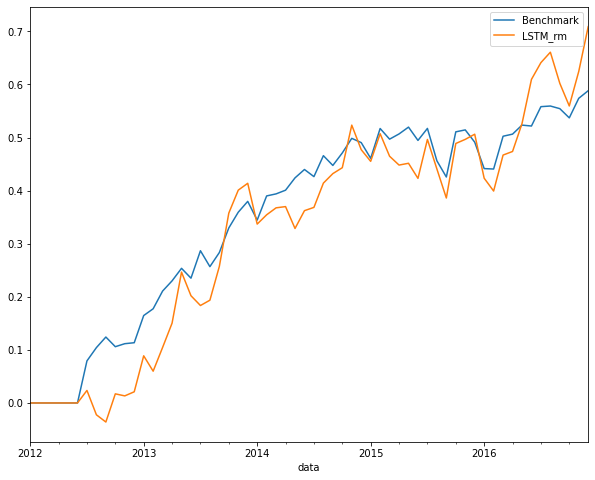

In [38]:
df = plotPortfolioReturns(d_res)

In [39]:
getStatistic(d_stat).to_csv('Lstm_stat_2012_2016.csv')
df.to_csv('Lstm_drawdown_2012_2016.csv')

# 2016-2021 
SPY, TLT, GLD, IYR

In [3]:
config_cerebro = {
    'assets':['SPY', 'TLT', 'GLD', 'RWO'],
    'benchmark':'SPY',
    'startd': datetime(2016, 1, 1),
    'endd'  : datetime(2021, 12, 31),
    'set_coc' : True,
    'set_coo' : False,
    'cash': 11000.0,
    'stocks_df':None,
    'benchmark_df':None
}

params = {
    'DataCounter': 125,
    'RebalanceDay': 22,
    'reserveCash': 1000.0,
    'printlog': 0,
    'benchmarkUse': True,
    'resetModel':False, 
    'resetModelStep':4,
    'model':Model(),
    'model_params':{
        'model_n':'LSTM',
        'collectData':False,
        'epochs':1000}
}
d_res = {}
d_stat = {}

config_cerebro['stocks_df'] = pdr.DataReader(config_cerebro['assets'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')
config_cerebro['benchmark_df'] = pdr.DataReader(config_cerebro['benchmark'], 
                start=config_cerebro['startd'],
                end=config_cerebro['endd'],
                data_source='yahoo')

Starting Portfolio Value: 11000.00
Final Portfolio Value: 11787.45


,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,1.31268,28.355375,0.051221,11787.44902


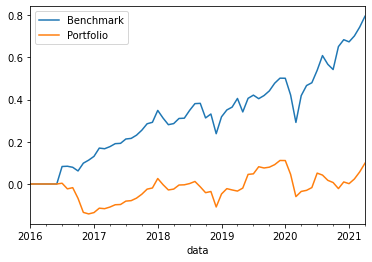

In [4]:
params['model'] = Model()
params['resetModel'] = True

d_stat[get_name(params)], d_res[get_name(params)], ah = backtest(config_cerebro, DynRebalance, m_name=get_name(params), plot=False, **params)
display(d_stat[get_name(params)])
d_res[get_name(params)].plot()

In [5]:
plotAllocation(ah.dropna())

In [6]:
getStatistic(d_stat).sort_values(by=['Sharp_Ratio'], ascending=False)

,CAGR,Max_Drawdown,Sharp_Ratio,Value
LSTM_rm,1.31268,28.355375,0.051221,11787.44902


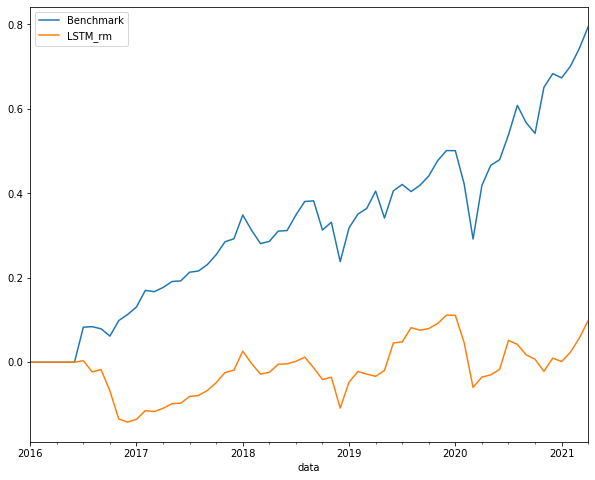

In [7]:
df = plotPortfolioReturns(d_res)

In [8]:
getStatistic(d_stat).to_csv('Lstm_stat_etf_2016_2021.csv')
df.to_csv('Lstm_drawdown_etf_2016_2021.csv')